In [2]:
# ! pip install shap

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from pyod.models.ecod import ECOD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import lightgbm as lgb

import prince
import matplotlib.cm as cm
import plotly.express as px
import shap
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
random_state = 33

# 1. Load the data

In [5]:
# Load datasets
customers_df = pd.read_csv("customers_data.csv")
orders_df = pd.read_csv("orders_data.csv")
products_df = pd.read_csv("products_data.csv")

# Convert date columns to datetime format
customers_df["signup_date"] = pd.to_datetime(customers_df["signup_date"])
orders_df["order_date"] = pd.to_datetime(orders_df["order_date"])
# products_df["Stocking_Date"] = pd.to_datetime(products_df["Stocking_Date"])


In [6]:
print(customers_df.shape, orders_df.shape, products_df.shape)

(1150, 5) (12744, 7) (500, 13)


# 2. Feature engineering

## 2.1 Merge product and customer data with orders

In [9]:
products_df.head()

,product_id,category,subcategory,price,cost,Inventory_Batch,Stocking_Date,Total_Inventory,XS_stock,S_stock,M_stock,L_stock,XL_stock
0,1,Clothing,Cardigan,373.0,224.0,1,2022-10-02,11.0,0.0,4.0,2.0,3.0,2.0
1,2,Clothing,Cardigan,424.0,254.0,1,2019-12-16,1.0,1.0,0.0,0.0,0.0,0.0
2,3,Clothing,Cardigan,498.0,299.0,1,2023-09-23,9.0,2.0,2.0,0.0,3.0,2.0
3,4,Clothing,Cardigan,395.0,237.0,1,2022-12-12,7.0,0.0,1.0,2.0,3.0,1.0
4,5,Clothing,Cardigan,520.0,312.0,1,2024-12-06,15.0,2.0,3.0,4.0,4.0,2.0


In [10]:
# Merge orders with products to get price and category info
orders_merged = orders_df.merge(
    products_df[["product_id", "category", "subcategory", "price"]].drop_duplicates(),
    on="product_id",
    how="left"
)
print(orders_merged.shape)

(12744, 10)


In [11]:
orders_merged.head()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,category,subcategory,price
0,162,1070,2019-01-12,73,L,Completed,True,Clothing,Cardigan,448.0
1,475,783,2019-02-01,249,L,Completed,True,Clothing,Coats & Jackets,816.0
2,475,783,2019-02-01,67,S,Completed,True,Clothing,Cardigan,342.0
3,532,839,2019-02-05,249,XL,Completed,True,Clothing,Coats & Jackets,816.0
4,605,1061,2019-02-09,249,M,Returned,True,Clothing,Coats & Jackets,816.0


In [12]:
customers_df.head()

,customer_id,name,email,signup_date,location
0,1,David Pittman,ipearson@example.net,2023-11-07,FL
1,2,Susan Harding,tammy87@example.com,2020-08-02,FL
2,3,Madison Turner,april09@example.net,2021-05-26,NJ
3,4,Ryan Reilly,davidbrown@example.com,2024-10-05,MA
4,5,Andrea Diaz DDS,williamflores@example.com,2020-10-24,FL


In [22]:
# Add signup date and location
orders_merged = orders_merged.merge(
    customers_df[["customer_id", "signup_date", "location"]],
    on="customer_id",
    how="left"
).sort_values(["customer_id", "order_id", "order_date"]).reset_index(drop=True)
print(orders_merged.shape)

(12744, 12)


In [24]:
orders_merged.head()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,category,subcategory,price,signup_date,location
0,13942,1,2024-03-14,93,XL,Completed,True,Clothing,Cardigan,355.0,2023-11-07,FL
1,13958,1,2024-03-16,74,XS,Requested,False,Clothing,Cardigan,452.0,2023-11-07,FL
2,13958,1,2024-03-16,211,S,Completed,True,Clothing,Shirts & Tops,298.0,2023-11-07,FL
3,13958,1,2024-03-16,222,XL,Requested,False,Clothing,Shirts & Tops,292.0,2023-11-07,FL
4,13958,1,2024-03-16,248,S,Requested,False,Clothing,Coats & Jackets,873.0,2023-11-07,FL


## 2.2 Generate features

In [27]:
# Get today's date
current_date = datetime(2024, 12, 31)

In [29]:
# Aggregate on order-level
order_totals = orders_merged.groupby(["customer_id", "order_id"]).agg(
    order_total=("price", "sum"),
    order_date=("order_date", "first")
).sort_values(["customer_id", "order_date"]).reset_index()

In [31]:
order_totals.shape

(7190, 4)

In [33]:
order_totals.head()

,customer_id,order_id,order_total,order_date
0,1,13942,355.0,2024-03-14
1,1,13958,1915.0,2024-03-16
2,1,14083,2013.0,2024-04-05
3,1,14790,933.0,2024-08-03
4,2,7020,2220.0,2020-09-20


### 2.2.1 Spending behaviour features

In [36]:
# # Calculate days between orders
# order_totals["prev_order_date"] = order_totals.groupby("customer_id")["order_date"].shift(1)
# order_totals["days_between"] = (order_totals["order_date"] - order_totals["prev_order_date"]).dt.days
# order_totals.head()

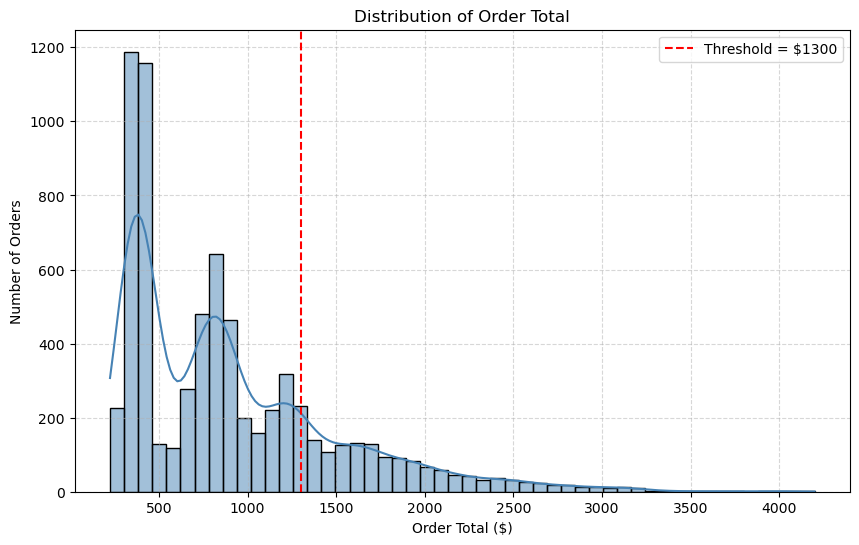

Order Total Quantiles:
0.25     398.00
0.50     783.00
0.75    1209.00
0.90    1750.20
0.95    2113.55
0.99    2853.00
Name: order_total, dtype: float64
----------------------------------------------
Threshold > $1200 → 1837 orders (25.5%)
Threshold > $1300 → 1470 orders (20.4%)
Threshold > $1400 → 1262 orders (17.6%)
Threshold > $1500 → 1122 orders (15.6%)
Threshold > $1600 → 958 orders (13.3%)


In [38]:
# Determine high value threshold

# Plot distribution of order_total
plt.figure(figsize=(10, 6))
sns.histplot(order_totals["order_total"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Order Total")
plt.xlabel("Order Total ($)")
plt.ylabel("Number of Orders")
plt.grid(True, linestyle='--', alpha=0.5)
plt.axvline(1300, color='red', linestyle='--', label='Threshold = $1300')
plt.legend()
plt.show()

# Examine percentiles to help determine a reasonable cutoff
quantiles = order_totals["order_total"].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("Order Total Quantiles:")
print(quantiles)

print("----------------------------------------------")

# Compare how many orders exceed each candidate threshold
thresholds = [1200, 1300, 1400, 1500, 1600]

for t in thresholds:
    count = (order_totals["order_total"] > t).sum()
    pct = count / len(order_totals) * 100
    print(f"Threshold > ${t:.0f} → {count} orders ({pct:.1f}%)")


threshold = 1300: the elbow and also around 0.75 quantile

In [41]:
# Generate features

spending = order_totals.groupby("customer_id").agg(
    customer_lifetime_value=("order_total", "sum"),
#     avg_order_value=("order_total", "mean"),
    std_order_value=("order_total", "std"),
    high_value_order_ratio=("order_total", lambda x: (x > 1300).mean())
).reset_index()

spending["std_order_value"] = spending["std_order_value"].fillna(0)
spending["customer_lifetime_value"] = spending["customer_lifetime_value"].fillna(0)

print(spending.shape)

(1070, 4)


In [43]:
spending.head()

,customer_id,customer_lifetime_value,std_order_value,high_value_order_ratio
0,1,5216.0,798.799933,0.500000
1,2,10693.0,767.717548,0.300000
2,3,8183.0,715.671201,0.250000
3,5,8870.0,627.299015,0.181818
4,6,2855.0,569.330821,0.250000


In [45]:
# Transform the features
# Why? K-Means groups data based on Euclidean distance to centroids, which works best with roughly circular (not skewed or elongated) clusters.

#------------- log not useful --------------------------------------------
# # Apply log1p transformation (handles skew + avoids log(0))
# spending["log_customer_lifetime_value"] = np.log1p(spending["customer_lifetime_value"])
# # spending["log_avg_order_value"]         = np.log1p(spending["avg_order_value"])
# spending["log_std_order_value"]         = np.log1p(spending["std_order_value"])


# spending["high_value_ratio_bucket"] = pd.cut(
#     spending["high_value_order_ratio"],
#     bins=[-0.01, 0.1, 0.3, 1.0],
#     labels=["Low", "Mid", "High"]
# )

# # Apply Yeo-Johnson transformation
# pt = PowerTransformer(method='yeo-johnson')

# pt_transformed = pt.fit_transform(spending[["customer_lifetime_value", "std_order_value"]])

# # Save back to DataFrame
# spending["pt_clv"] = pt_transformed[:, 0]
# spending["pt_std_order"] = pt_transformed[:, 1]

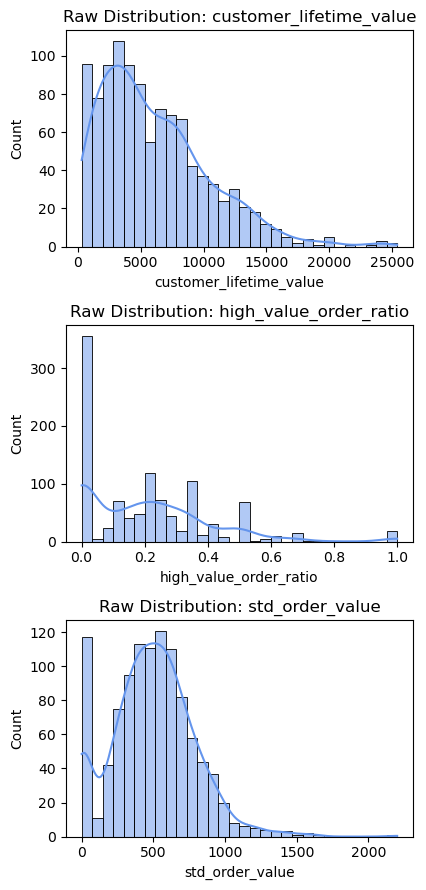

In [47]:
# Pairing each raw feature with its bucketed counterpart
feature_pairs = [
    ("customer_lifetime_value", "pt_clv"),
#     ("avg_order_value"        , "log_avg_order_value"),
    ("high_value_order_ratio" , "high_value_ratio_bucket"),
    ("std_order_value"        , "pt_std_order")
]

# Plot setup
n_features = len(feature_pairs)
plt.figure(figsize=(8, 3 * n_features))

for i, (raw_col, trans_col) in enumerate(feature_pairs):
    # Raw
    plt.subplot(n_features, 2, 2 * i + 1)
    sns.histplot(spending[raw_col].dropna(), kde=True, bins=30, color="cornflowerblue")
    plt.title(f"Raw Distribution: {raw_col}")
    plt.xlabel(raw_col)

#     if 'bucket' in trans_col:
#         # Bucketed
#         plt.subplot(n_features, 2, 2 * i + 2)
#         spending[trans_col].value_counts(normalize=True).sort_index().plot(
#             kind="bar", color="darkorange", edgecolor="black"
#         )
#         plt.title(f"Bucketed: {trans_col}")
#         plt.ylabel("Proportion")
#         plt.xticks(rotation=45)
        
#     else:
       
#         plt.subplot(n_features, 2, 2 * i + 2)
#         sns.histplot(spending[trans_col].dropna(), kde=True, bins=30, color="darkblue")
#         plt.title(f"Scale-Loged Distribution: {trans_col}")
#         plt.xlabel(trans_col)

plt.tight_layout()
plt.show()


### 2.2.2 Engagement pattern features

In [50]:
engagement = order_totals.groupby("customer_id").agg(
    recency_days=("order_date", lambda x: (current_date - x.max()).days),
    frequency=("order_id", "nunique")
).reset_index()

recent_orders = order_totals[order_totals["order_date"] >= pd.to_datetime("2024-12-01")]
order_count_recent = recent_orders.groupby("customer_id").size().reset_index(name="order_count_last_30_days")
engagement = engagement.merge(order_count_recent, on = 'customer_id', how = 'left')

engagement["order_count_last_30_days"] = engagement["order_count_last_30_days"].fillna(0)

print(engagement.shape)

(1070, 4)


In [52]:
engagement.head()

,customer_id,recency_days,frequency,order_count_last_30_days
0,1,150,4,0.0
1,2,756,10,0.0
2,3,112,8,0.0
3,5,246,11,0.0
4,6,160,4,0.0


In [54]:
# engagement["recency_days_bucket"] = pd.cut(
#     engagement["recency_days"],
#     bins=[-1, 30, 90, 180, np.inf],
#     labels=["Active", "Warm", "Cold", "Dormant"]
# )

# engagement["frequency_bucket"] = pd.cut(
#     engagement["frequency"],
#     bins=[0, 1, 5, np.inf],
#     labels=["One-time", "Repeat", "Frequent"]
# )

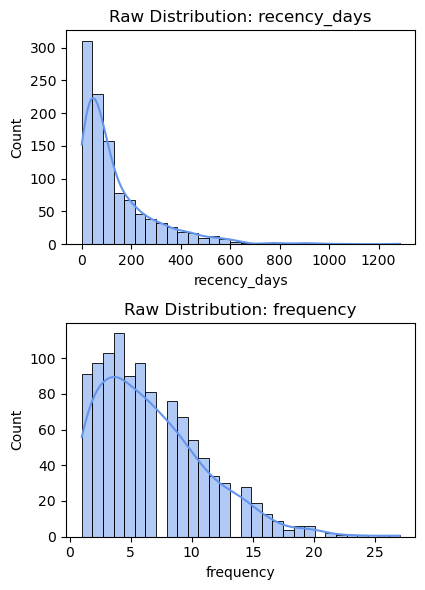

In [58]:
# Pairing each raw feature with its bucketed counterpart
feature_pairs = [
    ("recency_days", "recency_days_bucket"),
    ("frequency", "frequency_bucket")
]

# Plot setup
n_features = len(feature_pairs)
plt.figure(figsize=(8, 3 * n_features))

for i, (raw_col, trans_col) in enumerate(feature_pairs):
    # Raw
    plt.subplot(n_features, 2, 2 * i + 1)
    sns.histplot(engagement[raw_col].dropna(), kde=True, bins=30, color="cornflowerblue")
    plt.title(f"Raw Distribution: {raw_col}")
    plt.xlabel(raw_col)

#     if 'bucket' in trans_col:
#         # Bucketed
#         plt.subplot(n_features, 2, 2 * i + 2)
#         engagement[trans_col].value_counts(normalize=True).sort_index().plot(
#             kind="bar", color="darkorange", edgecolor="black"
#         )
#         plt.title(f"Bucketed: {trans_col}")
#         plt.ylabel("Proportion")
#         plt.xticks(rotation=45)
        
#     else:
#         plt.subplot(n_features, 2, 2 * i + 2)
#         sns.histplot(engagement[trans_col].dropna(), kde=True, bins=30, color="darkblue")
#         plt.title(f"Scale-Loged Distribution: {trans_col}")
#         plt.xlabel(trans_col)

plt.tight_layout()
plt.show()


In [59]:
# engagement.drop(columns=['frequency'],inplace=True)

### 2.2.3 Product diversity features

In [ ]:
# product_behavior = orders_merged.groupby("customer_id").agg(
#     category_diversity=("category", pd.Series.nunique),
#     top_subcategory=("subcategory", lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown")
# ).reset_index()
# print(product_behavior.shape)

In [ ]:
# product_behavior.head()

### 2.2.4 Customer profile features
Is_local feature: Given that our physical store is in Wellesley, MA, the majority of our customers are located in MA. So city-level location cannot add any useful distinction power. Creating a is_local feature can better help with the segmentation. 

In [62]:
first_order = pd.DataFrame(orders_df.groupby("customer_id")["order_date"].min().reset_index(name="first_order_date"))
first_order["tenure_days"] = (current_date - first_order["first_order_date"]).dt.days

profile = customers_df.merge(
    first_order[["customer_id", "tenure_days"]],
    on="customer_id", how="left"
)
# profile["is_local"] = customers_df["location"].str.contains("MA").map({True: "local", False: "non_local"})
profile["tenure_days"] = profile["tenure_days"].fillna(0)

profile = profile[["customer_id", "tenure_days"]]
print(profile.shape)

(1150, 2)


In [64]:
# profile["tenure_days_bucket"] = pd.cut(
#     profile["tenure_days"],
#     bins=[-1,450,980,1460,2180],
#     labels=["Inactive", "Short", "Medium", "Long"]
# )

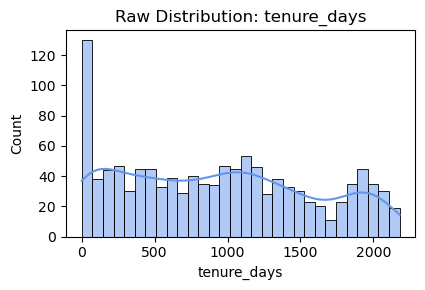

In [66]:
# Pairing each raw feature with its bucketed counterpart
feature_pairs = [
    ("tenure_days", "tenure_days_bucket")
]

# Plot setup
n_features = len(feature_pairs)
plt.figure(figsize=(8, 3 * n_features))

for i, (raw_col, trans_col) in enumerate(feature_pairs):
    # Raw
    plt.subplot(n_features, 2, 2 * i + 1)
    sns.histplot(profile[raw_col].dropna(), kde=True, bins=30, color="cornflowerblue")
    plt.title(f"Raw Distribution: {raw_col}")
    plt.xlabel(raw_col)

#     if 'bucket' in trans_col:
#         # Bucketed
#         plt.subplot(n_features, 2, 2 * i + 2)
#         profile[trans_col].value_counts(normalize=True).sort_index().plot(
#             kind="bar", color="darkorange", edgecolor="black"
#         )
#         plt.title(f"Bucketed: {trans_col}")
#         plt.ylabel("Proportion")
#         plt.xticks(rotation=45)
        
#     else:
#         plt.subplot(n_features, 2, 2 * i + 2)
#         sns.histplot(profile[trans_col].dropna(), kde=True, bins=30, color="darkblue")
#         plt.title(f"Scale-Loged Distribution: {trans_col}")
#         plt.xlabel(trans_col)

plt.tight_layout()
plt.show()


In [78]:
# import matplotlib.pyplot as plt

# # Count customers by location
# location_counts = profile["is_local"].value_counts().sort_values(ascending=False)

# # Plot the distribution
# plt.figure(figsize=(6, 4))
# location_counts.plot(kind='bar', color='lightblue', edgecolor='black')
# plt.title("Customer Distribution by Location")
# plt.xlabel("Customer State")
# plt.ylabel("Number of Customers")
# plt.xticks(rotation=0, ha='center')
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


In [68]:
profile.head()

,customer_id,tenure_days
0,1,292.0
1,2,1563.0
2,3,1280.0
3,4,0.0
4,5,1363.0


In [95]:
# profile.drop(columns=['tenure_days'],inplace=True)

### 2.2.5 Merge all features

In [93]:
customer_features = engagement \
    .merge(spending, on="customer_id") \
    .merge(profile, on="customer_id")\


print(customer_features.shape)

(1070, 8)


In [95]:
customer_features.head()

,customer_id,recency_days,frequency,order_count_last_30_days,customer_lifetime_value,std_order_value,high_value_order_ratio,tenure_days
0,1,150,4,0.0,5216.0,798.799933,0.500000,292.0
1,2,756,10,0.0,10693.0,767.717548,0.300000,1563.0
2,3,112,8,0.0,8183.0,715.671201,0.250000,1280.0
3,5,246,11,0.0,8870.0,627.299015,0.181818,1363.0
4,6,160,4,0.0,2855.0,569.330821,0.250000,548.0


In [97]:
# customer_features.to_csv("customer_features.csv", index = False)

## 2.3 Preprocessing

In [99]:
# Define feature groups
categorical_features = []
numeric_features = [i for i in list(customer_features.columns) if i not in categorical_features and i != 'customer_id']
print(numeric_features)

['recency_days', 'frequency', 'order_count_last_30_days', 'customer_lifetime_value', 'std_order_value', 'high_value_order_ratio', 'tenure_days']


In [101]:
# Define preprocessing pipelines
## turns location into one-hot coding
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore", drop='first'))]
)
## standardizes numeric features (mean = 0, std = 1) so they’re all on the same scale.
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
## combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Fit and transform the data
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
pipeline_fit = pipeline.fit(customer_features)

processed_data = pd.DataFrame(
    pipeline_fit.transform(customer_features),
    columns=pipeline_fit.get_feature_names_out()
)


In [103]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['recency_days', 'frequency',
                                                   'order_count_last_30_days',
                                                   'customer_lifetime_value',
                                                   'std_order_value',
                                                   'high_value_order_ratio',
                                                   'tenure_days'])]))])

In [105]:
processed_data.shape

(1070, 7)

## 2.3 Outliers

In [107]:
clf = ECOD()
clf.fit(processed_data)
outliers = clf.predict(processed_data) 

processed_data["outliers"] = outliers

# Data without outliers
processed_data_no_outliers = processed_data[processed_data["outliers"] == 0]
processed_data_no_outliers = processed_data_no_outliers.drop(["outliers"], axis = 1)

print(processed_data_no_outliers.shape) 

(963, 7)


In [109]:
processed_data_no_outliers.shape

(963, 7)

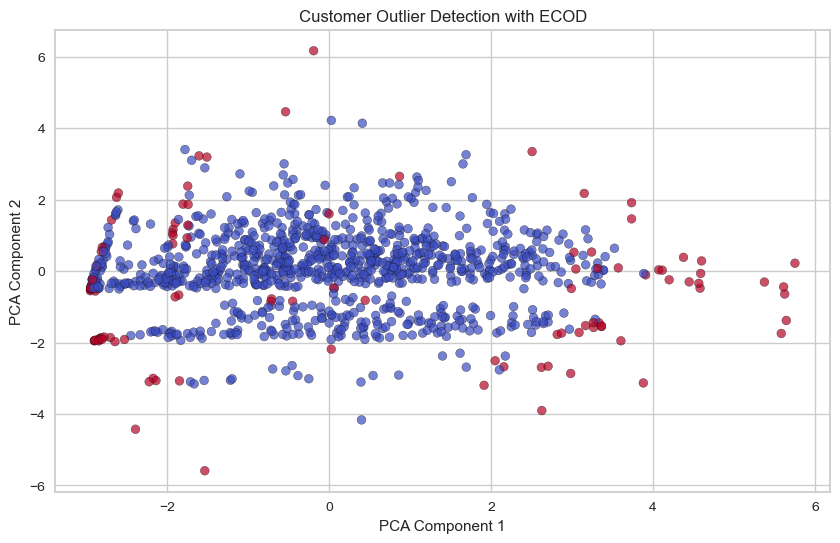

In [111]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(processed_data)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    X_vis[:, 0], X_vis[:, 1],
    c=processed_data["outliers"],  # 0 = inlier, 1 = outlier
    cmap="coolwarm", edgecolor='k', s=40, alpha=0.7
)
plt.title("Customer Outlier Detection with ECOD")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


# 3. Modeling

## 3.1 K-means
### Test for the best K

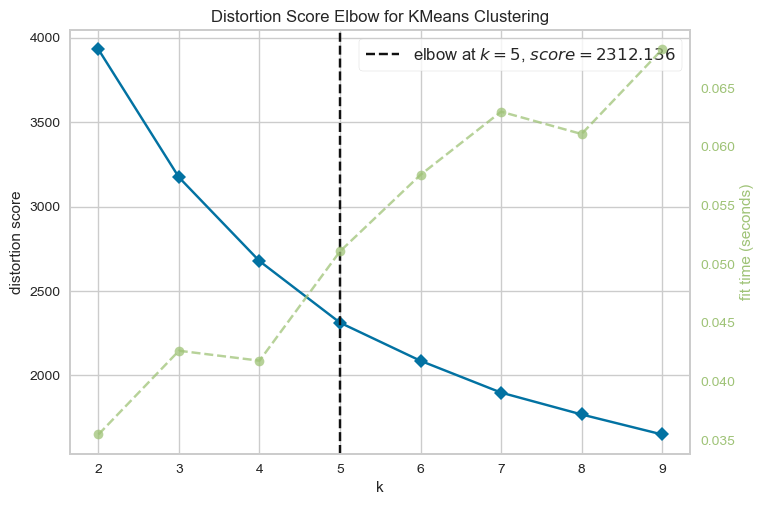

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [113]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=random_state, n_init=10)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(processed_data_no_outliers)        # Fit the data to the visualizer
visualizer.show()    

### Run the Kmeans with the best K

In [116]:
km = KMeans(n_clusters=5,
            init='k-means++', 
            n_init=10,
            max_iter=100, 
            random_state=random_state)

clusters_predict = km.fit_predict(processed_data_no_outliers)

### Evaluate with scores

In [119]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## average similarity measure of each cluster with its most similar cluster
## The minimum value of the DB Index is 0, whereas a smaller value represents a better model that produces better clusters
davies = davies_bouldin_score(processed_data_no_outliers, clusters_predict)

## the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
## The higher the index the more separable the clusters.
calinski = calinski_harabasz_score(processed_data_no_outliers, clusters_predict)

## Its value ranges from -1 to 1.
## A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
## 1 is the ideal value and indicates that clusters are very dense and nicely separated.
silhouette = silhouette_score(processed_data_no_outliers, clusters_predict)

print("Final KMeans Clustering Evaluation (k=5):")
print(f"Davies-Bouldin Score: {davies:.4f}")
print(f"Calinski-Harabasz Score: {calinski:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

## Davies seems acceptable (>2 is good)
## Calinski looks better than city-level location
## Silhouette is telling me that the model is not well separated (>0.5 then good)

Final KMeans Clustering Evaluation (k=5):
Davies-Bouldin Score: 1.1651
Calinski-Harabasz Score: 322.0555
Silhouette Score: 0.2845


### Visualize with PCA method

In [174]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=random_state
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=random_state
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df, 
                        x=columns[0], 
                        y=columns[1], 
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 900, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()

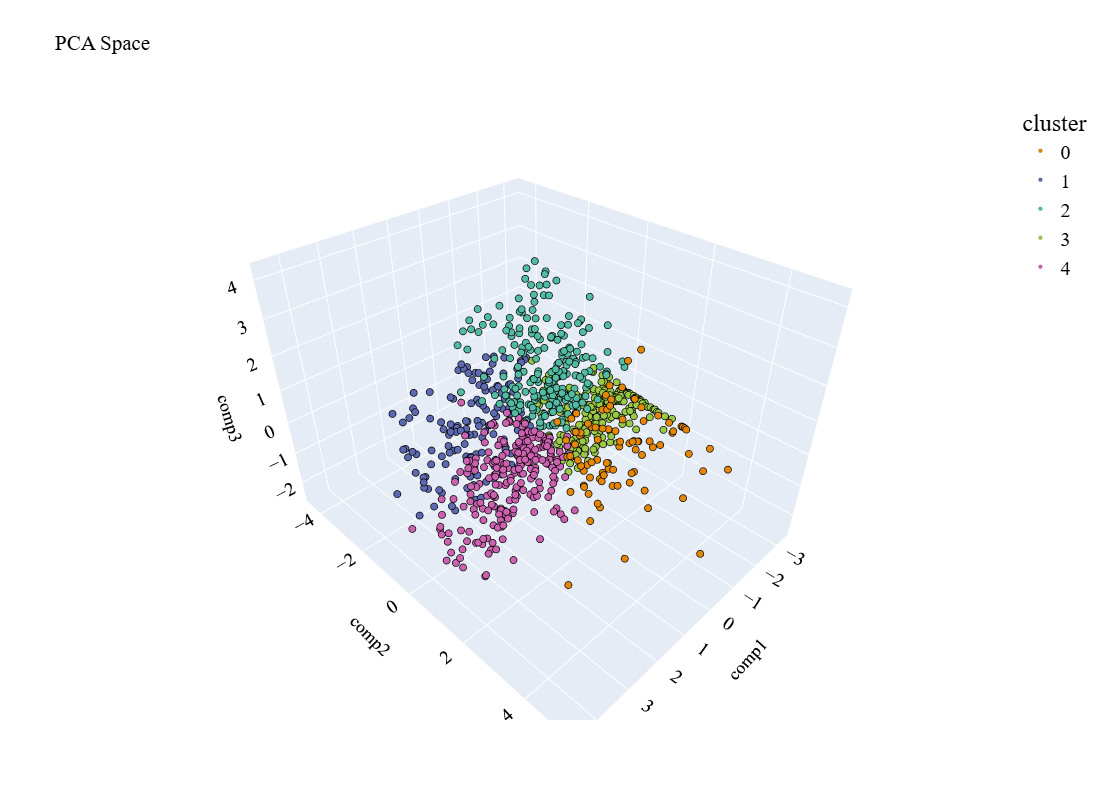

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.970        42.43%                     42.43%
1              1.434        20.49%                     62.92%
2              1.399        19.98%                     82.91%


In [176]:
pca_3d_object, df_pca_3d = get_pca_3d(processed_data_no_outliers, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

Conclusion:
1. It can be seen that even though each cluster has a dense concentration of data points around its centroid, the boundaries between clusters are not clearly separated. This is in accordance with the information provided by the metrics: low Silhouette  score states that clusters overlap, or blend into each other.
2. we can see the 3 components account for 72.57% of variability, which is pretty good but still a bit lower than the ideal 80%


### Visualize with t-SNE 

When we apply the PCA method, since it is a linear algorithm, it is not capable of capturing more complex relationships. Luckily there is a method called t-SNE, which is capable of capturing these complex polynomial relationships. This can help us visualize, since with the previous method we have not had much success.

In [220]:
start_time = time.time()

# sampling_data = processed_data_no_outliers.sample(frac=0.5, replace=True, random_state=random_state)
# sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=random_state)[0].values

df_tsne_3d = TSNE(
                  n_components=3,    
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(processed_data_no_outliers)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = clusters_predict
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

print(f"Elapsed time: {(time.time() - start_time)/60:.2f} minutes")

Elapsed time: 5.64 minutes


### Summarize Kmeans model performance

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 7
[LightGBM] [Info] Start training from score -2.427402
[LightGBM] [Info] Start training from score -1.866107
[LightGBM] [Info] Start training from score -1.458407
[LightGBM] [Info] Start training from score -1.309372
[LightGBM] [Info] Start training from score -1.368795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

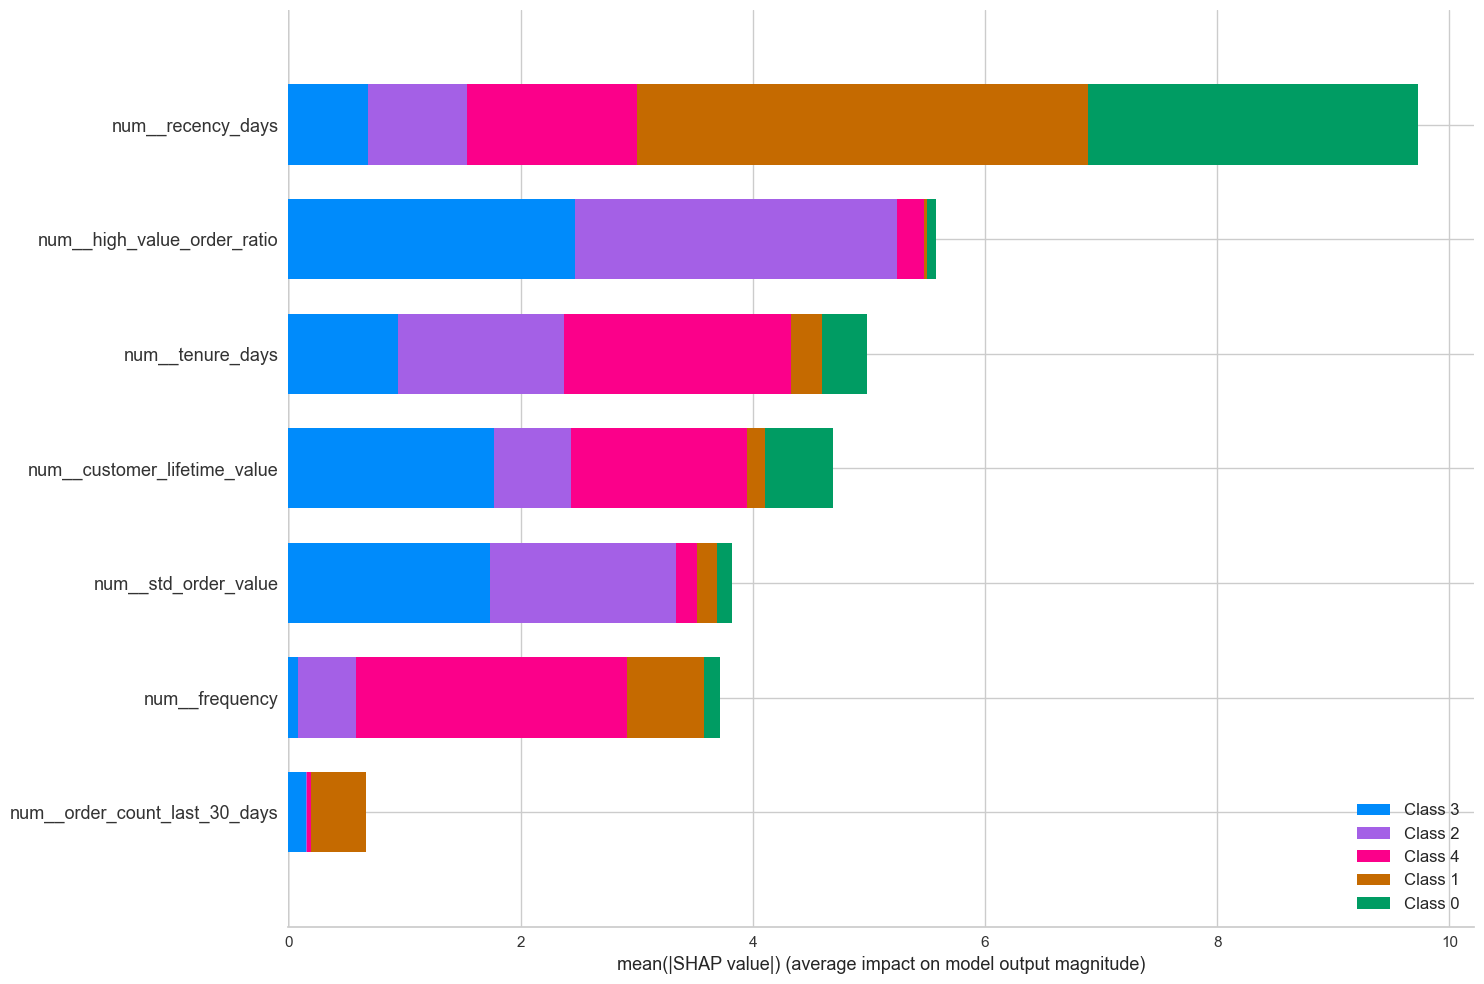

In [121]:
# We create the LGBMClassifier model and train it
## quite powerful and works well having categorical and numerical variables.
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X=processed_data_no_outliers, y=clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(processed_data_no_outliers)
shap.summary_plot(shap_values_km, processed_data_no_outliers, plot_type="bar", plot_size=(15, 10))

**A step to know which feature is less powerful**
- feature is_local has the least predictive power. Also, cluster number 0 (green) is mainly differentiated by the recency variable. can be considered to remove it.

In [123]:
# what is decisive for each cluster
processed_data_no_outliers["cluster"] = clusters_predict

processed_data_no_outliers.groupby('cluster').agg(
    {
#         'cat__is_local_non_local': lambda x: x.value_counts().index[0],
        'num__recency_days':'mean',
        'num__frequency': 'mean',
        'num__order_count_last_30_days': 'mean',
        'num__customer_lifetime_value':'mean',
        'num__std_order_value':'mean',
        'num__high_value_order_ratio': 'mean',
        'num__tenure_days': 'mean'

    }
).reset_index()
# ## cluster 4: Loyal power Buyers: long-time, high CLV, steady mid-range spenders
# 🎁 Loyalty or referral rewards; 🔁 Exclusive offers to retain;📣 Promote subscription or bundle plans
# ## cluster 2: Infrequent but Big Spenders, high-end product seeker: new, rarely buy, but go big
# 🛍 Premium product targeting💎 Flash deals on high-end goods📨 Cart abandonment + upsell flows
# ## cluster 3: low-engagement Low-Value Shoppers: new, cold, low-spending 
# 💸 Entry-level incentives (first-time buyer coupons)🔁 Try product education or low-barrier items💬 Highlight social proof or customer reviews
# ## cluster 1: Mid-term warm but recently avtive 
# 🧭 Onboarding flow, first 30-day engagement push🔁 Cross-sell based on recent behavior🏆 Convert into loyalty members
# ## cluster 0: long-time lapsed Mid-Value: Past buyers, now dormant
# 🧼 Reactivation campaign: "We miss you"💥 Offer time-sensitive win-back discounts🎯 Personalize content to what they used to buy

,cluster,num__recency_days,num__frequency,num__order_count_last_30_days,num__customer_lifetime_value,num__std_order_value,num__high_value_order_ratio,num__tenure_days
0,0,2.236261,-0.252501,-0.509288,-0.373976,-0.168605,-0.252472,0.334508
1,1,-0.791801,0.435571,1.629413,0.355437,0.139518,-0.029904,0.363475
2,2,-0.093251,-0.482454,-0.307260,-0.248441,0.781937,0.932840,-0.463431
3,3,-0.153880,-0.717426,-0.291719,-0.836954,-0.882603,-0.906607,-0.766960
4,4,-0.021838,0.906411,-0.509288,0.868672,0.299323,0.050285,0.955820


## 4. Segmentation table on customer level

In [125]:
processed_data.head()

,num__recency_days,num__frequency,num__order_count_last_30_days,num__customer_lifetime_value,num__std_order_value,num__high_value_order_ratio,num__tenure_days,outliers
0,0.082236,-0.613338,-0.509288,-0.199577,1.045163,1.461183,-1.139289,0
1,4.019002,0.739800,-0.509288,1.064562,0.938110,0.485125,0.915794,0
2,-0.164624,0.288754,-0.509288,0.485232,0.758854,0.241111,0.458210,0
3,0.705882,0.965323,-0.509288,0.643798,0.454486,-0.091637,0.592413,0
4,0.147199,-0.613338,-0.509288,-0.744516,0.254834,0.241111,-0.725362,0


In [127]:
processed_data_no_outliers.head()

,num__recency_days,num__frequency,num__order_count_last_30_days,num__customer_lifetime_value,num__std_order_value,num__high_value_order_ratio,num__tenure_days,cluster
0,0.082236,-0.613338,-0.509288,-0.199577,1.045163,1.461183,-1.139289,2
1,4.019002,0.739800,-0.509288,1.064562,0.938110,0.485125,0.915794,0
2,-0.164624,0.288754,-0.509288,0.485232,0.758854,0.241111,0.458210,4
3,0.705882,0.965323,-0.509288,0.643798,0.454486,-0.091637,0.592413,4
4,0.147199,-0.613338,-0.509288,-0.744516,0.254834,0.241111,-0.725362,2


### Attach cluster to customer

In [129]:
join_key = list(i for i in processed_data_no_outliers.columns if i != 'cluster')
join_key

['num__recency_days',
 'num__frequency',
 'num__order_count_last_30_days',
 'num__customer_lifetime_value',
 'num__std_order_value',
 'num__high_value_order_ratio',
 'num__tenure_days']

In [131]:
processed_data_cluster = processed_data.merge(processed_data_no_outliers
                    ,how = 'left'
                    ,on = join_key)

In [133]:
processed_data_cluster

,num__recency_days,num__frequency,num__order_count_last_30_days,num__customer_lifetime_value,num__std_order_value,num__high_value_order_ratio,num__tenure_days,outliers,cluster
0,0.082236,-0.613338,-0.509288,-0.199577,1.045163,1.461183,-1.139289,0,2.0
1,4.019002,0.739800,-0.509288,1.064562,0.938110,0.485125,0.915794,0,0.0
2,-0.164624,0.288754,-0.509288,0.485232,0.758854,0.241111,0.458210,0,4.0
3,0.705882,0.965323,-0.509288,0.643798,0.454486,-0.091637,0.592413,0,4.0
4,0.147199,-0.613338,-0.509288,-0.744516,0.254834,0.241111,-0.725362,0,2.0
...,...,...,...,...,...,...,...,...,...
1065,-0.807759,1.641892,1.376312,2.141976,0.661500,0.066814,1.518898,1,NaN
1066,-0.729803,-1.064384,1.376312,-1.116580,-0.597931,-0.978962,-1.305830,0,3.0
1067,-0.859729,-0.838861,1.376312,-0.907005,-0.300815,-0.978962,-1.459436,0,3.0
1068,-0.762285,2.092938,1.376312,1.580650,0.403207,-0.368926,1.617529,0,1.0


### Attach cluster to order

In [135]:
orders_merged_cluster = orders_merged.merge(processed_data_cluster, how = 'left'
                    , left_on = 'customer_id', right_index  = True)

In [137]:
orders_merged_cluster.head()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,category,subcategory,price,...,location,num__recency_days,num__frequency,num__order_count_last_30_days,num__customer_lifetime_value,num__std_order_value,num__high_value_order_ratio,num__tenure_days,outliers,cluster
0,13942,1,2024-03-14,93,XL,Completed,True,Clothing,Cardigan,355.0,...,FL,4.019002,0.7398,-0.509288,1.064562,0.93811,0.485125,0.915794,0.0,0.0
1,13958,1,2024-03-16,74,XS,Requested,False,Clothing,Cardigan,452.0,...,FL,4.019002,0.7398,-0.509288,1.064562,0.93811,0.485125,0.915794,0.0,0.0
2,13958,1,2024-03-16,211,S,Completed,True,Clothing,Shirts & Tops,298.0,...,FL,4.019002,0.7398,-0.509288,1.064562,0.93811,0.485125,0.915794,0.0,0.0
3,13958,1,2024-03-16,222,XL,Requested,False,Clothing,Shirts & Tops,292.0,...,FL,4.019002,0.7398,-0.509288,1.064562,0.93811,0.485125,0.915794,0.0,0.0
4,13958,1,2024-03-16,248,S,Requested,False,Clothing,Coats & Jackets,873.0,...,FL,4.019002,0.7398,-0.509288,1.064562,0.93811,0.485125,0.915794,0.0,0.0


In [139]:
cluster_fav_subcategory = (orders_merged_cluster.groupby(['cluster','subcategory']).size()
        .reset_index(name = 'count')
        .sort_values(by=['cluster','count'], ascending=[True, False])
).drop_duplicates(subset = ['cluster'])
cluster_fav_subcategory.drop(columns=['count'], inplace=True)
cluster_fav_subcategory

,cluster,subcategory
1,0.0,Cardigan
10,1.0,Cardigan
25,2.0,Shirts & Tops
28,3.0,Cardigan
37,4.0,Cardigan


In [141]:
cluster_fav_products = (orders_merged_cluster.groupby(['cluster','product_id']).size()
                            .reset_index(name = 'count')
                            .sort_values(by=['cluster','count'], ascending=[True, False])
                     # keep first 5 products for each cluster
                            .groupby('cluster')
                            .head(5)
                     # aggregate 5 products into list
                            .groupby('cluster')['product_id']
                            .apply(list)
                            .reset_index(name='top_5_products')
)
cluster_fav_products

,cluster,top_5_products
0,0.0,"[145, 311, 123, 139, 326]"
1,1.0,"[145, 249, 175, 310, 139]"
2,2.0,"[286, 303, 311, 312, 145]"
3,3.0,"[123, 315, 145, 249, 286]"
4,4.0,"[249, 303, 123, 145, 286]"


### Attach cluster to feature table

In [144]:
customer_features_cluster = customer_features.merge(processed_data_cluster[['cluster']], how = 'left', left_index = True, right_index  = True)
customer_features_cluster.head()

,customer_id,recency_days,frequency,order_count_last_30_days,customer_lifetime_value,std_order_value,high_value_order_ratio,tenure_days,cluster
0,1,150,4,0.0,5216.0,798.799933,0.500000,292.0,2.0
1,2,756,10,0.0,10693.0,767.717548,0.300000,1563.0,0.0
2,3,112,8,0.0,8183.0,715.671201,0.250000,1280.0,4.0
3,5,246,11,0.0,8870.0,627.299015,0.181818,1363.0,4.0
4,6,160,4,0.0,2855.0,569.330821,0.250000,548.0,2.0


In [146]:
def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

customer_features_cluster_summary = customer_features_cluster.groupby("cluster",dropna=True).agg(
    mean_recency_days = ("recency_days", "mean"),
    mean_high_value_order_ratio=("high_value_order_ratio", "mean"),
    mean_tenure = ("tenure_days", "mean"),
    sum_customer_lifetime_value = ("tenure_days", "sum"),
    count=("customer_id", "count"),

    mean_frequency = ("frequency", "mean"),
    mean_clv=("customer_lifetime_value", "mean"),
    mean_order_count_last_30_days=("order_count_last_30_days", "mean"),
    mean_std_order_value=("std_order_value", "mean"),
    iqr_recency_days = ('recency_days',iqr),
    iqr_frequency = ('frequency',iqr),
    iqr_order_count_last_30_days = ('order_count_last_30_days',iqr),
    iqr_CLV = ('customer_lifetime_value',iqr),
    iqr_std_order_value = ('std_order_value',iqr),
    iqr_high_value_order_ratio = ('high_value_order_ratio',iqr),
    iqr_tenure_days = ('tenure_days',iqr)
).reset_index()
customer_features_cluster_summary

,cluster,mean_recency_days,mean_high_value_order_ratio,mean_tenure,sum_customer_lifetime_value,count,mean_frequency,mean_clv,mean_order_count_last_30_days,mean_std_order_value,iqr_recency_days,iqr_frequency,iqr_order_count_last_30_days,iqr_CLV,iqr_std_order_value,iqr_high_value_order_ratio,iqr_tenure_days
0,0.0,481.576471,0.148862,1203.494118,102297.0,85,5.600000,4460.400000,0.000000,446.386765,165.00,3.0,0.0,2973.00,275.205199,0.250000,647.00
1,1.0,15.456376,0.194467,1221.409396,181990.0,149,8.651007,7620.651007,1.134228,535.849149,13.00,5.0,0.0,3924.00,272.633508,0.216667,741.00
2,2.0,122.986607,0.391739,709.995536,159039.0,224,4.580357,5004.290179,0.107143,722.373000,130.25,3.0,0.0,2973.00,298.171415,0.250000,544.25
3,3.0,113.653846,0.014826,522.273077,135791.0,260,3.538462,2454.503846,0.115385,239.079971,111.50,3.0,0.0,2143.25,286.677478,0.000000,589.50
4,4.0,133.979592,0.210899,1587.755102,389000.0,245,10.738776,9844.289796,0.000000,582.247787,124.00,4.0,0.0,4243.00,216.730604,0.147727,633.00


### Segmentation Table

In [149]:
seg_table = customer_features_cluster_summary.merge(cluster_fav_subcategory, how = 'left', on = 'cluster').merge(cluster_fav_products, how = 'left', on = 'cluster')
seg_table

,cluster,mean_recency_days,mean_high_value_order_ratio,mean_tenure,sum_customer_lifetime_value,count,mean_frequency,mean_clv,mean_order_count_last_30_days,mean_std_order_value,iqr_recency_days,iqr_frequency,iqr_order_count_last_30_days,iqr_CLV,iqr_std_order_value,iqr_high_value_order_ratio,iqr_tenure_days,subcategory,top_5_products
0,0.0,481.576471,0.148862,1203.494118,102297.0,85,5.600000,4460.400000,0.000000,446.386765,165.00,3.0,0.0,2973.00,275.205199,0.250000,647.00,Cardigan,"[145, 311, 123, 139, 326]"
1,1.0,15.456376,0.194467,1221.409396,181990.0,149,8.651007,7620.651007,1.134228,535.849149,13.00,5.0,0.0,3924.00,272.633508,0.216667,741.00,Cardigan,"[145, 249, 175, 310, 139]"
2,2.0,122.986607,0.391739,709.995536,159039.0,224,4.580357,5004.290179,0.107143,722.373000,130.25,3.0,0.0,2973.00,298.171415,0.250000,544.25,Shirts & Tops,"[286, 303, 311, 312, 145]"
3,3.0,113.653846,0.014826,522.273077,135791.0,260,3.538462,2454.503846,0.115385,239.079971,111.50,3.0,0.0,2143.25,286.677478,0.000000,589.50,Cardigan,"[123, 315, 145, 249, 286]"
4,4.0,133.979592,0.210899,1587.755102,389000.0,245,10.738776,9844.289796,0.000000,582.247787,124.00,4.0,0.0,4243.00,216.730604,0.147727,633.00,Cardigan,"[249, 303, 123, 145, 286]"


In [151]:
cluster_names = {
    0: '💔Faded Luxe',
    1: '👑The Inner Circle',
    2: '💎Quiet High Spenders',
    3: '👀Window Shoppers',
    4: '🏆The Power Shoppers'
}

seg_table['cluster'] = seg_table['cluster'].replace(cluster_names)


In [153]:
seg_table

,cluster,mean_recency_days,mean_high_value_order_ratio,mean_tenure,sum_customer_lifetime_value,count,mean_frequency,mean_clv,mean_order_count_last_30_days,mean_std_order_value,iqr_recency_days,iqr_frequency,iqr_order_count_last_30_days,iqr_CLV,iqr_std_order_value,iqr_high_value_order_ratio,iqr_tenure_days,subcategory,top_5_products
0,💔Faded Luxe,481.576471,0.148862,1203.494118,102297.0,85,5.600000,4460.400000,0.000000,446.386765,165.00,3.0,0.0,2973.00,275.205199,0.250000,647.00,Cardigan,"[145, 311, 123, 139, 326]"
1,👑The Inner Circle,15.456376,0.194467,1221.409396,181990.0,149,8.651007,7620.651007,1.134228,535.849149,13.00,5.0,0.0,3924.00,272.633508,0.216667,741.00,Cardigan,"[145, 249, 175, 310, 139]"
2,💎Quiet High Spenders,122.986607,0.391739,709.995536,159039.0,224,4.580357,5004.290179,0.107143,722.373000,130.25,3.0,0.0,2973.00,298.171415,0.250000,544.25,Shirts & Tops,"[286, 303, 311, 312, 145]"
3,👀Window Shoppers,113.653846,0.014826,522.273077,135791.0,260,3.538462,2454.503846,0.115385,239.079971,111.50,3.0,0.0,2143.25,286.677478,0.000000,589.50,Cardigan,"[123, 315, 145, 249, 286]"
4,🏆The Power Shoppers,133.979592,0.210899,1587.755102,389000.0,245,10.738776,9844.289796,0.000000,582.247787,124.00,4.0,0.0,4243.00,216.730604,0.147727,633.00,Cardigan,"[249, 303, 123, 145, 286]"


In [155]:
seg_table.to_csv('Segmentation Summary.csv', index=False)